In [13]:
# Cell 1 — Imports, reproducibility, and small utilities
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [14]:
# Reproducibility (best-effort)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# This cell sets a random seed so the results are the same every time you run the notebook.

In [15]:
print("Python / NumPy / TensorFlow versions:", 
      sys.version if 'sys' in globals() else "python", np.__version__, tf.__version__)

Python / NumPy / TensorFlow versions: python 1.26.4 2.18.0


In [16]:
# Cell 2 — Stage (a): Load CIFAR-10 data and quick inspection
# CIFAR-10: 50k train, 10k test, images 32x32x3

from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train.shape:", x_train.shape, "y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape, "y_test.shape:", y_test.shape)

# number of classes
num_classes = 10


x_train.shape: (50000, 32, 32, 3) y_train.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3) y_test.shape: (10000, 1)


C:\Users\SAHIL KULKARNI\AppData\Local\Temp\ipykernel_10644\1493671178.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Label (raw): {int(y_train[25])}")


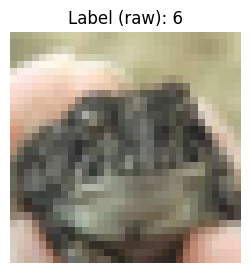

In [17]:
# Show one example (raw)
plt.figure(figsize=(3,3))
plt.imshow(x_train[25])
plt.title(f"Label (raw): {int(y_train[25])}")
plt.axis("off")
plt.show()

In [18]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# y_train and y_test are often shape (N,1). Make them 1D then one-hot encode.
y_train = y_train.reshape(-1) if y_train.ndim == 2 and y_train.shape[1] == 1 else y_train
y_test  = y_test.reshape(-1)  if y_test.ndim == 2  and y_test.shape[1] == 1 else y_test

from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

print("After preprocessing: x_train.shape =", x_train.shape, ", y_train_cat.shape =", y_train_cat.shape)

After preprocessing: x_train.shape = (50000, 32, 32, 3) , y_train_cat.shape = (50000, 10)


In [19]:
# ------------------ Cell 4 ------------------
# Data augmentation pipeline (must be executed BEFORE model definition)
# ---- Cell 4 ----
# Data augmentation pipeline (must be executed BEFORE model definition)
from tensorflow import keras

# Ensure num_classes exists (if not, set default)
try:
    num_classes
except NameError:
    num_classes = 10

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),       # random left-right flip
    keras.layers.RandomRotation(0.08),           # small random rotations
    keras.layers.RandomZoom(0.05),               # small random zooms
], name="data_augmentation")

# quick sanity check (optional)
print("Data augmentation pipeline created:", data_augmentation)



# This cell creates a data augmentation pipeline to make training images more varied.
# It randomly flips, rotates, and zooms images to prevent overfitting.
# This helps the model learn better and generalize to unseen data.

Data augmentation pipeline created: <Sequential name=data_augmentation, built=False>


In [20]:
# ------------------ Cell 5 ------------------
# Define model architecture (uses data_augmentation defined above)

from tensorflow import keras
from tensorflow.keras import layers, models

def build_cifar_cnn(data_aug_layer=None):
    """
    Builds a small CNN for CIFAR-10.
    If data_aug_layer is provided, it will be applied to the input.
    """
    inputs = keras.Input(shape=(32,32,3))
    x = data_aug_layer(inputs) if data_aug_layer is not None else inputs

    # Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(x)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    # Block 3
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv3')(x)

    # Classifier head
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(64, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="cifar_cnn")
    return model

# Build model using the augmentation layer created in Cell 4
model = build_cifar_cnn(data_augmentation)
model.summary()

# This cell defines and builds the CNN used for CIFAR-10.
# It applies the data augmentation layer (if given), then 3 convolutional blocks,
# flattens features, adds a dense + dropout head, and outputs class probabilities with softmax.
# Finally it constructs the Keras Model and prints a summary.

Model: "cifar_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Cell 6 — Stage (c): Compile model using SGD (as required)
# You can switch to Adam by changing optimizer below if you wish.

learning_rate = 0.01
momentum = 0.9

optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)
# Alternatively: optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",   # labels are one-hot encoded
    metrics=["accuracy"]
)

print("Model compiled with optimizer:", optimizer)

# This cell compiles the CNN model using the SGD optimizer.
# It sets the learning rate and momentum, then defines the optimizer.
# The model is compiled with categorical crossentropy loss (for one-hot labels)
# and accuracy as the evaluation metric.

Model compiled with optimizer: <keras.src.optimizers.sgd.SGD object at 0x00000150D3752ED0>


In [22]:
# ---- FIXED Cell 7 ----
batch_size = 64
epochs = 12

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_cifar_model.keras", save_best_only=True, monitor="val_loss"
)
earlystop_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# TRAIN: IMPORTANT - use y_train_cat (one-hot) to match categorical_crossentropy
history = model.fit(
    x_train, y_train_cat,
    validation_split=0.1,   # keep 10% of train as validation
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=2
)


# This cell trains the model and includes useful training callbacks.
# It sets batch size and number of epochs, then defines:
# - ModelCheckpoint: saves the best model during training.
# - EarlyStopping: stops training early if validation loss stops improving.
# - ReduceLROnPlateau: reduces learning rate when progress slows.
# The model is trained on the training data with 10% used for validation.

Epoch 1/12
704/704 - 47s - 66ms/step - accuracy: 0.2684 - loss: 1.9813 - val_accuracy: 0.3572 - val_loss: 1.7823 - learning_rate: 0.0100
Epoch 2/12
704/704 - 43s - 61ms/step - accuracy: 0.3938 - loss: 1.6667 - val_accuracy: 0.4558 - val_loss: 1.4924 - learning_rate: 0.0100
Epoch 3/12
704/704 - 42s - 60ms/step - accuracy: 0.4536 - loss: 1.5185 - val_accuracy: 0.5310 - val_loss: 1.3069 - learning_rate: 0.0100
Epoch 4/12
704/704 - 41s - 59ms/step - accuracy: 0.4930 - loss: 1.4192 - val_accuracy: 0.5430 - val_loss: 1.2489 - learning_rate: 0.0100
Epoch 5/12
704/704 - 41s - 58ms/step - accuracy: 0.5165 - loss: 1.3528 - val_accuracy: 0.5932 - val_loss: 1.1598 - learning_rate: 0.0100
Epoch 6/12
704/704 - 39s - 56ms/step - accuracy: 0.5361 - loss: 1.2994 - val_accuracy: 0.6024 - val_loss: 1.1116 - learning_rate: 0.0100
Epoch 7/12
704/704 - 39s - 56ms/step - accuracy: 0.5587 - loss: 1.2457 - val_accuracy: 0.6272 - val_loss: 1.0741 - learning_rate: 0.0100
Epoch 8/12
704/704 - 40s - 57ms/step - ac

In [23]:
# ---- Cell 8 ----
# Evaluate on test set and print results
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


313/313 - 4s - 13ms/step - accuracy: 0.6744 - loss: 0.9344
Test loss: 0.9344, Test accuracy: 0.6744


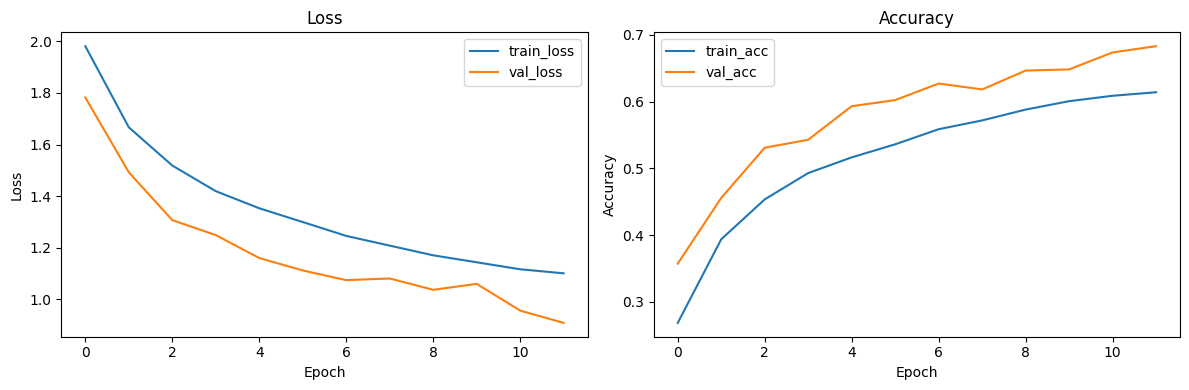

In [24]:
# ---- Cell 9 ----
# Plot training history (loss and accuracy)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout()
plt.show()


In [25]:
# ---- Cell 10 ----
# Save final model and helper: save is optional because ModelCheckpoint saved the best already
model.save("final_cifar_model.keras")
print("Model saved to final_cifar_model.keras")


Model saved to final_cifar_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


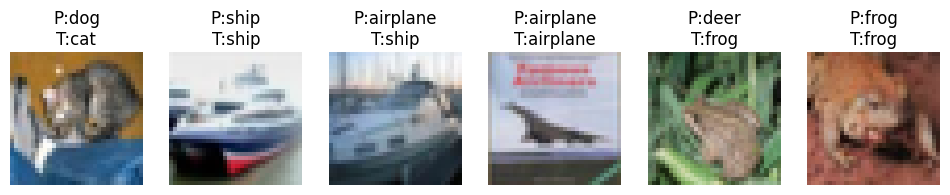

In [26]:
# ---- Cell 11 ----
# Single-image predict helper and sample display
import numpy as np

def predict_single_image(img, model, class_names=None):
    """
    img: a single image with shape (32,32,3) and pixel range [0,1] (float32)
    model: trained keras model
    class_names: optional list of class label names
    """
    x = np.expand_dims(img, axis=0).astype("float32")
    probs = model.predict(x)
    pred_idx = np.argmax(probs[0])
    if class_names:
        return pred_idx, class_names[pred_idx], probs[0][pred_idx]
    return pred_idx, probs[0][pred_idx]

# CIFAR-10 class names (optional)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# show some test predictions
n = 6
plt.figure(figsize=(12,4))
for i in range(n):
    idx = i  # or random index from test set
    img = x_test[idx]
    pred_idx, pred_prob = predict_single_image(img, model)[:2]
    true_label = y_test[idx]
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.title(f"P:{class_names[pred_idx]}\nT:{class_names[int(true_label)]}")
    plt.axis('off')
plt.show()
